# Text classification

In [22]:
import pandas as pd
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [24]:
embeddings_ada_2 = OpenAIEmbeddings(model='text-embedding-ada-002')
embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
embeddings_3_large = OpenAIEmbeddings(model='text-embedding-3-large')
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
bge_embed = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

In [25]:
df = pd.read_csv('IMDB Dataset.csv')
sampled_df = df.sample(n=600, random_state=42)
sampled_df['sentiment'] = sampled_df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
sampled_df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [26]:
labels = sampled_df['sentiment'].to_numpy()
review = sampled_df['review'].to_list()

In [27]:
# Generating dummy data for embeddings
embedding_1 = np.array([embeddings_ada_2.embed_query(text) for text in review])
embedding_2 = np.array([embeddings_3_small.embed_query(text) for text in review])
embedding_3 = np.array([embeddings_3_large.embed_query(text) for text in review])
embedding_4 = np.array([bge_embed.embed_query(text) for text in review])

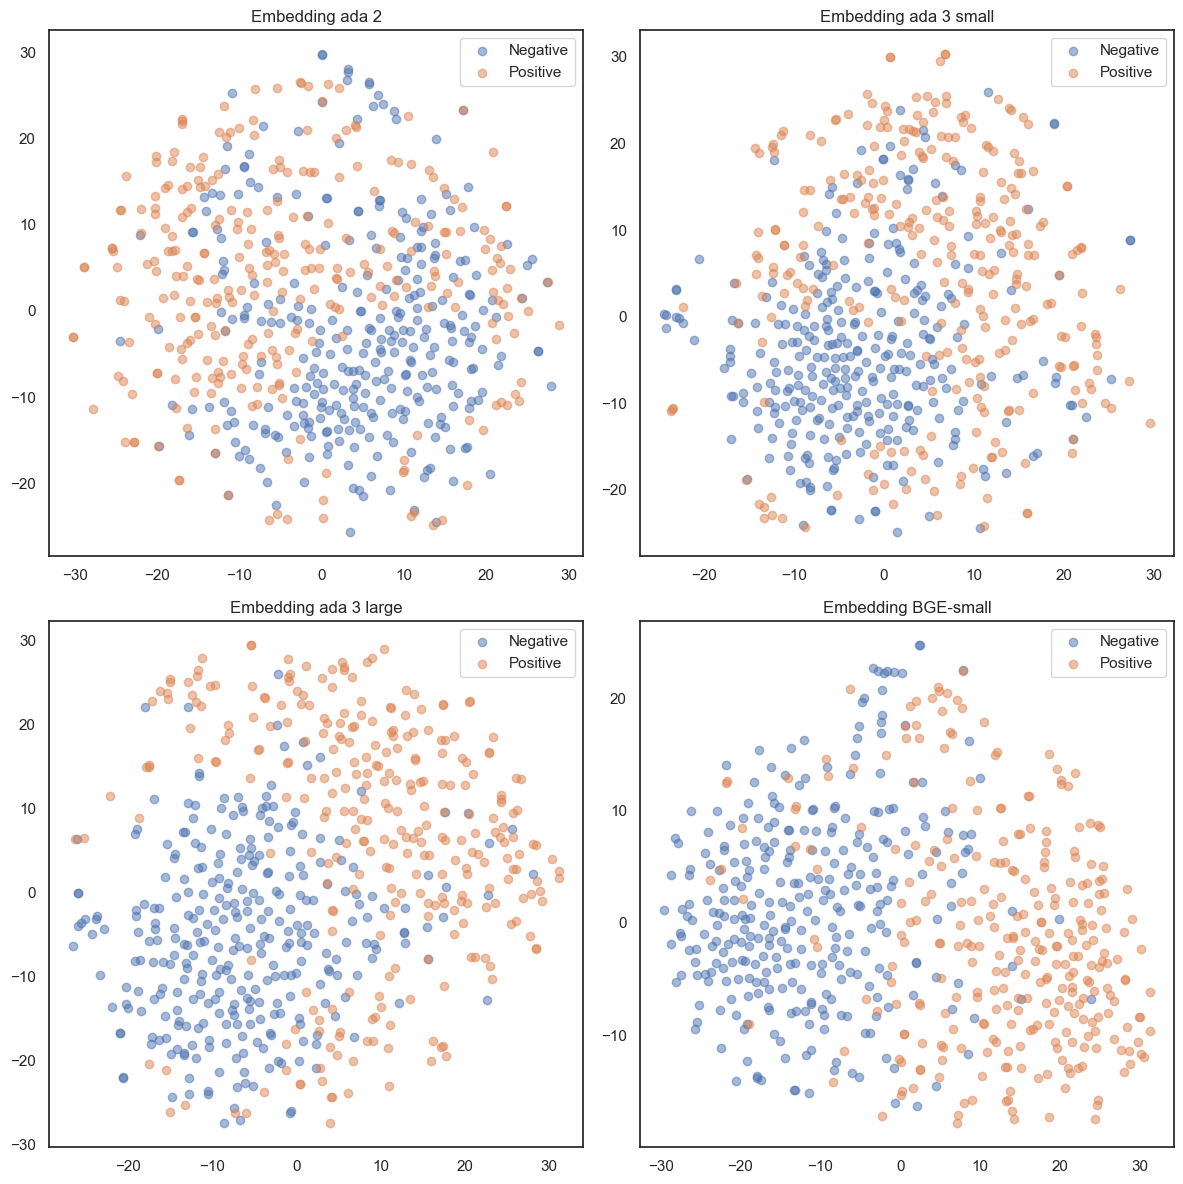

In [28]:
names=['ada 2', 'ada 3 small', 'ada 3 large', 'BGE-small']
# Function to perform t-SNE and plot
def tsne_plot(embeddings, labels):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, embedding in enumerate(embeddings):
        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(embedding)

        # Plot
        ax = axs[i//2, i%2]
        ax.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], label='Negative', alpha=0.5)
        ax.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], label='Positive', alpha=0.5)
        ax.set_title(f'Embedding {names[i]}')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Perform t-SNE and plot for all embeddings
tsne_plot([embedding_1, embedding_2, embedding_3, embedding_4], labels)

## Cosine similarity classifier

In [29]:
from sklearn.model_selection import train_test_split

np.random.seed(42)  # For reproducibility

# Split into train and test sets
embedding_1_train, embedding_1_test, label_train, label_test = train_test_split(embedding_1, labels, test_size=0.2, random_state=42)
embedding_2_train, embedding_2_test, _, _ = train_test_split(embedding_2, labels, test_size=0.2, random_state=42)
embedding_3_train, embedding_3_test, _, _ = train_test_split(embedding_3, labels, test_size=0.2, random_state=42)
embedding_4_train, embedding_4_test, _, _ = train_test_split(embedding_4, labels, test_size=0.2, random_state=42)

# Compute the central vector (mean vector) of the training set
embedding_1_central_vector = np.mean(embedding_1_train[label_train == 1], axis=0)
embedding_1_central_vector = embedding_1_central_vector / np.linalg.norm(embedding_1_central_vector)
embedding_2_central_vector = np.mean(embedding_2_train[label_train == 1], axis=0)
embedding_2_central_vector = embedding_2_central_vector / np.linalg.norm(embedding_2_central_vector)
embedding_3_central_vector = np.mean(embedding_3_train[label_train == 1], axis=0)
embedding_3_central_vector = embedding_3_central_vector / np.linalg.norm(embedding_3_central_vector)
embedding_4_central_vector = np.mean(embedding_4_train[label_train == 1], axis=0)
embedding_4_central_vector = embedding_4_central_vector / np.linalg.norm(embedding_4_central_vector)

(array([ 2.,  1.,  1.,  3.,  8.,  2.,  4.,  3., 11., 23., 18., 21., 42.,
        37., 30., 23.,  9.,  7.,  4.,  3.]),
 array([0.31794376, 0.33741289, 0.35688201, 0.37635114, 0.39582027,
        0.4152894 , 0.43475852, 0.45422765, 0.47369678, 0.49316591,
        0.51263503, 0.53210416, 0.55157329, 0.57104241, 0.59051154,
        0.60998067, 0.6294498 , 0.64891892, 0.66838805, 0.68785718,
        0.70732631]),
 <BarContainer object of 20 artists>)

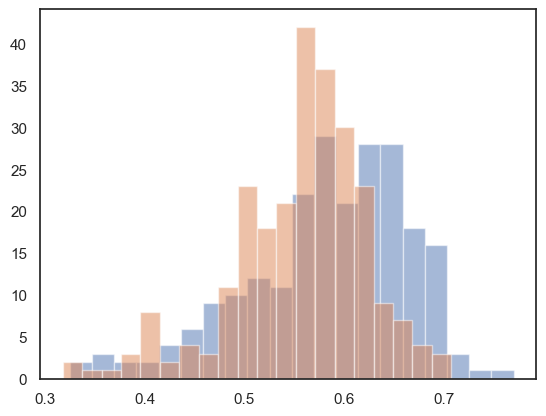

In [30]:
results = np.dot(embedding_3_train, embedding_3_central_vector)
plt.hist(results[label_train == 1], alpha = 0.5, bins=20)
plt.hist(results[label_train == 0], alpha = 0.5, bins=20)

Cosine similarity doesn't seem to perform and when we look at the distribution of cosine similarity between various vectors and the representative of the positive class we see that the distributions are mixed. Let's try the l2 norm as s measure of distance.

# Eucledian distance

(array([ 2.,  2.,  8., 12., 23., 38., 29., 27., 39., 22., 10., 18.,  7.,
         4.,  5.,  4.,  0.,  1.,  0.,  1.]),
 array([0.40976023, 0.41841753, 0.42707483, 0.43573213, 0.44438943,
        0.45304673, 0.46170403, 0.47036133, 0.47901863, 0.48767593,
        0.49633323, 0.50499053, 0.51364782, 0.52230512, 0.53096242,
        0.53961972, 0.54827702, 0.55693432, 0.56559162, 0.57424892,
        0.58290622]),
 <BarContainer object of 20 artists>)

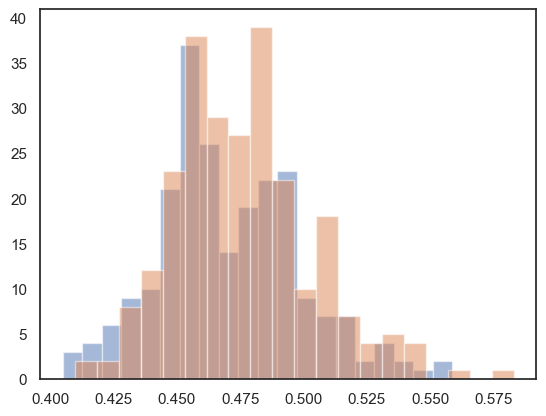

In [31]:
from scipy.spatial.distance import cdist

# Compute the central vector this time without normalization as we are computing the distance
embedding_1_central_vector = np.mean(embedding_1_train[label_train == 1], axis=0)
embedding_1_central_vector = embedding_1_central_vector
embedding_2_central_vector = np.mean(embedding_2_train[label_train == 1], axis=0)
embedding_2_central_vector = embedding_2_central_vector
embedding_3_central_vector = np.mean(embedding_3_train[label_train == 1], axis=0)
embedding_3_central_vector = embedding_3_central_vector
embedding_4_central_vector = np.mean(embedding_4_train[label_train == 1], axis=0)
embedding_4_central_vector = embedding_4_central_vector

# Compute the Euclidean distance between each training embedding and the central vector
results = cdist(embedding_1_train, embedding_1_central_vector.reshape(1, -1), 'euclidean').flatten()
plt.hist(results[label_train == 1], alpha = 0.5, bins=20)
plt.hist(results[label_train == 0], alpha = 0.5, bins=20)

This suffers from the same issue as the cosine classifier.

# SVM and KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import pandas as pd
import pickle

def train_evaluate_save(model, X_train, X_test, y_train, y_test, model_name, embedding_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Save the model
    with open(f'{model_name}_{embedding_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
    
    return {'model_name': f'{model_name}_{embedding_name}', 'f1_score': f1}

results = []

training_embeds = [embedding_1_train, embedding_2_train, embedding_3_train, embedding_4_train] 
testing_embeds = [embedding_1_test, embedding_2_test, embedding_3_test, embedding_4_test]
for X_train, X_test, md in zip(training_embeds, testing_embeds,names):
    results.append(train_evaluate_save(KNeighborsClassifier(), X_train, X_test, label_train, label_test, "KNN", md))
    results.append(train_evaluate_save(SVC(), X_train, X_test, label_train, label_test, "SVM-rbf", md))
    results.append(train_evaluate_save(SVC(kernel='sigmoid'), X_train, X_test, label_train, label_test, "SVM-sigmoid", md))
    results.append(train_evaluate_save(SVC(kernel='linear'), X_train, X_test, label_train, label_test, "SVM-linear", md))

results_df = pd.DataFrame(results)
results_df.to_csv('embedding_models_scores.csv', index=False)


In [33]:
results_df.head(16)

,model_name,f1_score
0,KNN_ada 2,0.765302
1,SVM-rbf_ada 2,0.891720
2,SVM-sigmoid_ada 2,0.883333
3,SVM-linear_ada 2,0.891720
4,KNN_ada 3 small,0.762738
5,SVM-rbf_ada 3 small,0.924953
6,SVM-sigmoid_ada 3 small,0.924953
7,SVM-linear_ada 3 small,0.933333
8,KNN_ada 3 large,0.875061
9,SVM-rbf_ada 3 large,0.924953


Among these it seems that SVM with ada 002 from open AI gives the best performance in terms of the f score.

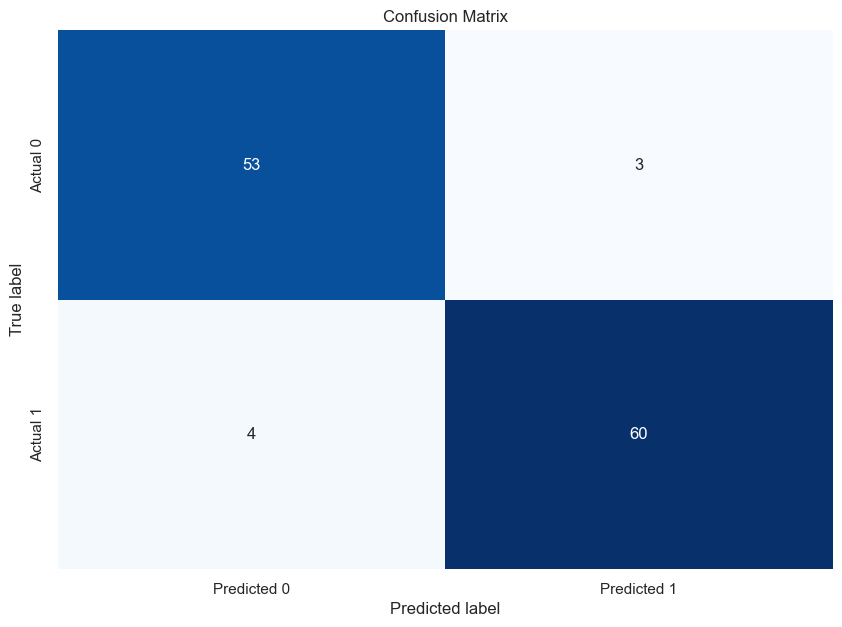

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

with open('SVM-sigmoid_ada 3 large.pkl', 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(embedding_3_test)
cm = confusion_matrix(label_test, y_pred)

# Set the Seaborn style for better aesthetics
sns.set(style="white")

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))  # Adjust the figure size as necessary
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],  # Adjust based on your classes
            yticklabels=['Actual 0', 'Actual 1'])       # Adjust based on your classes

# Add labels and a title for clarity
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## End to end pipeline

Here I build an end to end pipeline based on the best model and look at some of the failure cases

In [43]:
from tqdm import tqdm
with open('SVM-sigmoid_ada 3 large.pkl', 'rb') as f:
    model = pickle.load(f)

def analyze_sentiment(text):
    if model.predict(np.array(embeddings_3_large.embed_query(text)).reshape(1, -1)) == 1:
        return 'positive'
    else:
        return 'negative'
    
test_df = df.sample(n=200, random_state=54)

failures = []
for _, row in tqdm(test_df.iterrows()):
    if analyze_sentiment(row.review) != row.sentiment:
        failures.append([row.review, row.sentiment])

200it [01:20,  2.48it/s]


In [48]:
from pprint import pprint
pprint(failures)

[['Ants are shown in cartoons as being able to carry away chicken legs, '
  'watermellons, people, etc. This may be an admirable characteristic because '
  'ants carry the film Phase IV. This is not because they want to, but because '
  'they have to.<br /><br />The movie opens with a narrator cryptically '
  'explaining that some cosmic event has come over the earth, and that a '
  'fellow scientist has been working on the effect this disturbance has on the '
  'ant population. The movie is broken up in segments; the first part after '
  'the cosmic event is Phase I, and so on until the end of the movie, which is '
  "Phase IV.<br /><br />What is Phase IV? Who knows? We don't get to see that "
  'part; presumably it has something to do with the bonding of one of the '
  'scientists studying the ants and a girl who lived in the area. The girl, '
  'who looks like a cross between Alicia Silverstone and Liv Tyler, is mad at '
  'the ants because they killed her horse, but except for one 

These failure cases seem to be mostly due to the neutrality of the review which was labeled as positive or negative (but aren't either in my opinion.)